In [4]:
import os
import datetime
import sys
import random
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input, Layer, InputSpec
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from keras.applications import imagenet_utils

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
X_train = np.load('dataset/x_train.npy')
Y_train = np.load('dataset/y_train.npy')

In [6]:
def mean_iou(y_true, y_pred):
    th = 0.5
    y_pred_ = tf.cast(y_pred > th, tf.int32)
    metric = tf.keras.metrics.MeanIoU(num_classes=2)
    score = metric(y_true, y_pred_)
    return score

# tf.keras.metrics.MeanIoU(num_classes=2)

In [7]:
def train_model(model, X, Y, save_path, batch_size, epochs, model_name=""):
    model_name += datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    earlystopper = EarlyStopping(patience=50, verbose=1)
    checkpointer = ModelCheckpoint(save_path, verbose=1, save_best_only=False)

    log_dir = "drive/MyDrive/NETS KERAS/logs/fit/" + model_name
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=1)

    results = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=epochs, 
                      callbacks=[earlystopper, checkpointer, tensorboard_callback])

    return results

In [8]:
def show_result(prediction, image_index):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
    axes[0].imshow(X_train[image_index])
    axes[1].imshow(prediction[image_index, ..., 0] > 0.5)

# FCN

In [9]:
from keras.layers import UpSampling2D, MaxPooling2D, Activation
from keras.applications.vgg16 import VGG16

# FCN (FCN_Vgg16_32s) model
base_model = VGG16(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), include_top=False)
base_out = base_model.output
up = UpSampling2D(32, interpolation='bilinear')(base_out)
conv = Conv2D(1, (1, 1))(up)
output = Activation('sigmoid')(conv)

fcn_model = Model(inputs=[base_model.input], outputs=[output])
fcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
fcn_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)      

In [10]:
# train_model(fcn_model, X_train, Y_train, 'drive/MyDrive/fcn2_crosswalks.h5', 32, 100, 'fcn_new')

# SEGNET

In [11]:
from keras.layers import UpSampling2D

# Build SEG-NET model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

conv_1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv_1_1 = Dropout(0.1) (conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_1_1)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_1)
conv_2_1 = Dropout(0.1) (conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2_1)
pool_2 = MaxPooling2D(2)(conv_2_2)
                      
conv_3_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_2)
conv_3_1 = Dropout(0.2) (conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_3_1)
pool_3 = MaxPooling2D(2)(conv_3_2)
                      
conv_4_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_3)
conv_4_1 = Dropout(0.2) (conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_4_1)
pool_4 = MaxPooling2D(2)(conv_4_2)              
             
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conv_up_1_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(up_1)
conv_up_1_1 = Dropout(0.2) (conv_up_1_1)
conv_up_1_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_up_1_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conv_up_2_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up_2)
conv_up_2_1 = Dropout(0.2) (conv_up_2_1)
conv_up_2_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_2_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conv_up_3_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(up_3)
conv_up_3_1 = Dropout(0.1) (conv_up_3_1)
conv_up_3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_3_1)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conv_up_4_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up_4)
conv_up_4_1 = Dropout(0.1) (conv_up_4_1)
conv_up_4_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_up_4_1)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_up_4_2)


segnet_model = Model(inputs=[inputs], outputs=[outputs])
segnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

segnet_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)     

In [12]:
# train_model(segnet_model, X_train, Y_train, 'drive/MyDrive/segnet_crosswalks.h5', 32, 100, 'segnet')

# UNET

In [13]:
from keras.layers import UpSampling2D, Reshape, Add

# Build U-NET model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

conv_1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
conv_1_1 = Dropout(0.1) (conv_1_1)
conv_1_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_1_1)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool_1)
conv_2_1 = Dropout(0.1) (conv_2_1)
conv_2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_2_1)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_2)
conv_3_1 = Dropout(0.2) (conv_3_1)
conv_3_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_3_1)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_3)
conv_4_1 = Dropout(0.2) (conv_4_1)
conv_4_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_4_1)
pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_4)
conv_5_1 = Dropout(0.3) (conv_5_1)
conv_5_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_5_1)

up_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv_5_2) 
conc_1 = concatenate([conv_4_2, up_1])
conv_up_1_1 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc_1)
conv_up_1_1 = Dropout(0.2) (conv_up_1_1)
conv_up_1_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_up_1_1)

up_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv_up_1_2) 
conc_2 = concatenate([conv_3_2, up_2])
conv_up_2_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc_2)
conv_up_2_1 = Dropout(0.2) (conv_up_2_1)
conv_up_2_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_up_2_1)

up_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv_up_2_2)
conc_3 = concatenate([conv_2_2, up_3])
conv_up_3_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc_3)
conv_up_3_1 = Dropout(0.1) (conv_up_3_1)
conv_up_3_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_up_3_1)

up_4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv_up_3_2)
conc_4 = concatenate([conv_1_2, up_4])
conv_up_4_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conc_4)
conv_up_4_1 = Dropout(0.1) (conv_up_4_1)
conv_up_4_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_up_4_1)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_up_4_2)

unet_model = Model(inputs=[inputs], outputs=[outputs])
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
unet_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 256, 256, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 256, 256, 16) 0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 2320        dropout_8[0][0]                  
_______________________________________________________________________________________

In [14]:
# train_model(unet_model, X_train, Y_train, 'drive/MyDrive/unet2_crosswalks.h5', 32, 100, 'unet2')

# DEEPLAB

In [15]:
import tensorflow.compat.v1 as tf
from keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Input,DepthwiseConv2D,add,Dropout,AveragePooling2D,Concatenate
from keras.models import Model
from keras.applications import imagenet_utils
from keras.utils import conv_utils, data_utils

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"

def normalize_data_format(value):
    if value is None:
        value = K.image_data_format()
    data_format = value.lower()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('The `data_format` argument must be one of '
                         '"channels_first", "channels_last". Received: ' +
                         str(value))
    return data_format

class BilinearUpsampling(Layer):

    def __init__(self, upsampling=(2, 2), data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)
        self.data_format = normalize_data_format(data_format)
        self.upsampling = conv_utils.normalize_tuple(upsampling, 2, 'size')
        self.input_spec = InputSpec(ndim=4)

    def compute_output_shape(self, input_shape):
        height = self.upsampling[0] * \
            input_shape[1] if input_shape[1] is not None else None
        width = self.upsampling[1] * \
            input_shape[2] if input_shape[2] is not None else None
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        return tf.image.resize_bilinear(inputs, (int(inputs.shape[1]*self.upsampling[0]),
                                                   int(inputs.shape[2]*self.upsampling[1])))

    def get_config(self):
        config = {'size': self.upsampling,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
def xception_downsample_block(x,channels,top_relu=False):
    ##separable conv1
    if top_relu:
        x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    ##separable conv2
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    ##separable conv3
    x=DepthwiseConv2D((3,3),strides=(2,2),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    return x

def res_xception_downsample_block(x,channels):
    res=Conv2D(channels,(1,1),strides=(2,2),padding="same",use_bias=False)(x)
    res=BatchNormalization()(res)
    x=xception_downsample_block(x,channels)
    x=add([x,res])
    return x

def xception_block(x,channels):
    ##separable conv1
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    
    ##separable conv2
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    
    ##separable conv3
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(channels,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    return x

def res_xception_block(x,channels):
    res=x
    x=xception_block(x,channels)
    x=add([x,res])
    return x

def aspp(x,input_shape,out_stride):
    b0=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    b0=BatchNormalization()(b0)
    b0=Activation("relu")(b0)
    
    b1=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)
    b1=Conv2D(256,(1,1),padding="same",use_bias=False)(b1)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)
    
    b2=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)
    b2=Conv2D(256,(1,1),padding="same",use_bias=False)(b2)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)

    b3=DepthwiseConv2D((3,3),dilation_rate=(18,18),padding="same",use_bias=False)(x)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)
    b3=Conv2D(256,(1,1),padding="same",use_bias=False)(b3)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)
    
    out_shape=int(input_shape[0]/out_stride)
    b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
    b4=Conv2D(256,(1,1),padding="same",use_bias=False)(b4)
    b4=BatchNormalization()(b4)
    b4=Activation("relu")(b4)
    b4=BilinearUpsampling((out_shape,out_shape))(b4)
    
    x=Concatenate()([b4,b0,b1,b2,b3])
    return x

def deeplabv3_plus(input_shape=(512,512,3),out_stride=16,num_classes=21):
    img_input=Input(shape=input_shape)
    x=imagenet_utils.preprocess_input(img_input, mode='tf')
    x=Conv2D(32,(3,3),strides=(2,2),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Conv2D(64,(3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=res_xception_downsample_block(x,128)

    res=Conv2D(256,(1,1),strides=(2,2),padding="same",use_bias=False)(x)
    res=BatchNormalization()(res)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    skip=BatchNormalization()(x)
    x=Activation("relu")(skip)
    x=DepthwiseConv2D((3,3),strides=(2,2),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=add([x,res])
    
    x=xception_downsample_block(x,728,top_relu=True)
    
    for i in range(16):
        x=res_xception_block(x,728)

    res=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
    res=BatchNormalization()(res)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(728,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(1024,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)	
    x=add([x,res])
    
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(1536,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(1536,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Conv2D(2048,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    #aspp
    x=aspp(x,input_shape,out_stride)
    x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Dropout(0.9)(x)
    
    ##decoder 
    x=BilinearUpsampling((4,4))(x)
    dec_skip=Conv2D(48,(1,1),padding="same",use_bias=False)(skip)
    dec_skip=BatchNormalization()(dec_skip)
    dec_skip=Activation("relu")(dec_skip)
    x=Concatenate()([x,dec_skip])
    
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=DepthwiseConv2D((3,3),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    x=Conv2D(256,(1,1),padding="same",use_bias=False)(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    x=Conv2D(num_classes,(1,1),padding="same")(x)
    x=BilinearUpsampling((4,4))(x)
    x=Activation("sigmoid")(x)
    model=Model(img_input,x)
    
    # weights_path = data_utils.get_file('deeplabv3_weights_tf_dim_ordering_tf_kernels.h5', WEIGHTS_PATH_X, cache_subdir='models')
    # model.load_weights(weights_path, by_name=True)
        
    return model



deepLab_model=deeplabv3_plus((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 16, 1)
deepLab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
deepLab_model.summary()



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 256, 256, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 256, 256, 3) 0           tf_op_layer_RealDiv[0][0]        
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 128, 128, 32) 864         tf_op_layer_Sub[0][0]            
_______________________________________________________________________________________

In [16]:
# train_model(deepLab_model, X_train, Y_train, 'drive/MyDrive/deeplab_crosswalks.h5', 16, 100, 'deeplab')

# UNET X

In [17]:
from keras.layers import UpSampling2D, Reshape, Add, DepthwiseConv2D

def separableConv(x, channels):
    x=DepthwiseConv2D((3,3),padding="same")(x)
    x=Conv2D(channels, (1,1),padding="same", activation="relu")(x)
    return x


# Build U-NET model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#s = Lambda(lambda x: x / 255) (inputs)

conv_1_1 = separableConv(inputs, 16)
conv_1_1 = Dropout(0.1) (conv_1_1)
conv_1_2 = separableConv(conv_1_1, 16)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = separableConv(pool_1, 32)
conv_2_1 = Dropout(0.1) (conv_2_1)
conv_2_2 = separableConv(conv_2_1, 32)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = separableConv(pool_2, 64)
conv_3_1 = Dropout(0.2) (conv_3_1)
conv_3_2 = separableConv(conv_3_1, 64)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = separableConv(pool_3, 128)
conv_4_1 = Dropout(0.2) (conv_4_1)
conv_4_2 = separableConv(conv_4_1, 128)
pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = separableConv(pool_4, 256)
conv_5_1 = Dropout(0.3) (conv_5_1)
conv_5_2 = separableConv(conv_5_1, 256)

up_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv_5_2) 
conc_1 = concatenate([conv_4_2, up_1])
conv_up_1_1 = separableConv(conc_1, 128)
conv_up_1_1 = Dropout(0.2) (conv_up_1_1)
conv_up_1_2 = separableConv(conv_up_1_1, 128)

up_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv_up_1_2) 
conc_2 = concatenate([conv_3_2, up_2])
conv_up_2_1 = separableConv(conc_2, 64)
conv_up_2_1 = Dropout(0.2) (conv_up_2_1)
conv_up_2_2 = separableConv(conv_up_2_1, 64)

up_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv_up_2_2)
conc_3 = concatenate([conv_2_2, up_3])
conv_up_3_1 = separableConv(conc_3, 32)
conv_up_3_1 = Dropout(0.1) (conv_up_3_1)
conv_up_3_2 = separableConv(conv_up_3_1, 32)

up_4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv_up_3_2)
conc_4 = concatenate([conv_1_2, up_4])
conv_up_4_1 = separableConv(conc_4, 16)
conv_up_4_1 = Dropout(0.1) (conv_up_4_1)
conv_up_4_2 = separableConv(conv_up_4_1, 16)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv_up_4_2)

unet_x_model = Model(inputs=[inputs], outputs=[outputs])
unet_x_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
unet_x_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
depthwise_conv2d_68 (DepthwiseC (None, 256, 256, 3)  30          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 256, 256, 16) 64          depthwise_conv2d_68[0][0]        
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 16) 0           conv2d_115[0][0]                 
_______________________________________________________________________________________

In [18]:
# train_model(unet_x_model, X_train, Y_train, 'drive/MyDrive/unet_x_new_crosswalks.h5', 32, 100, 'unet_x_new')

# Compare nets

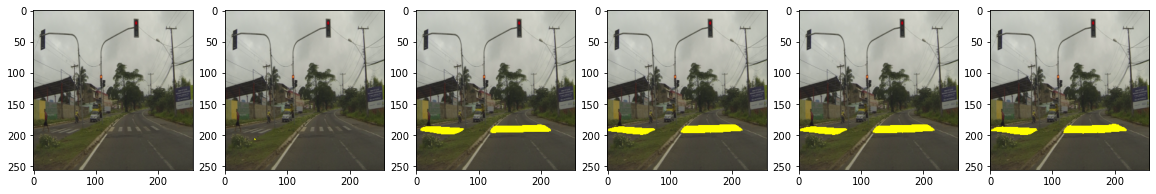

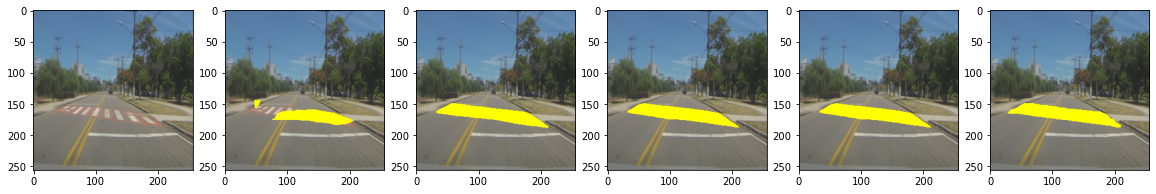

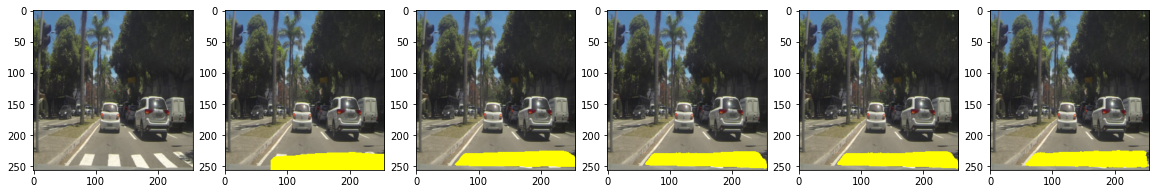

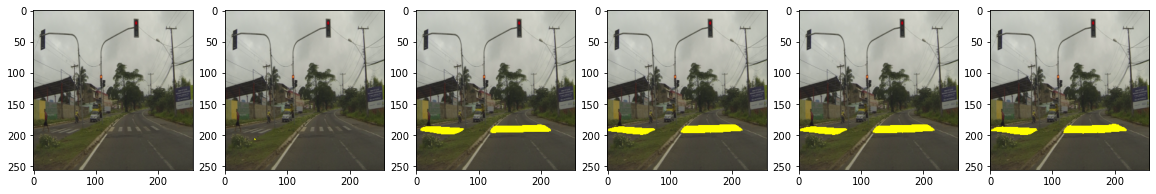

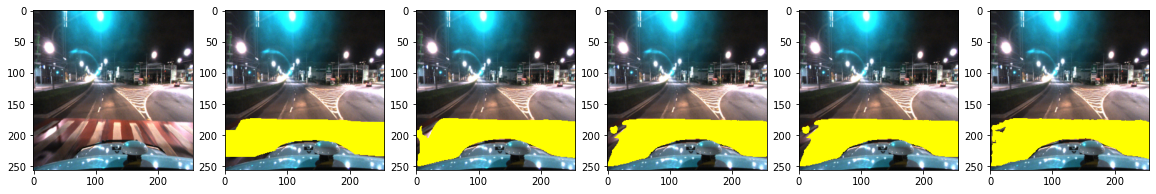

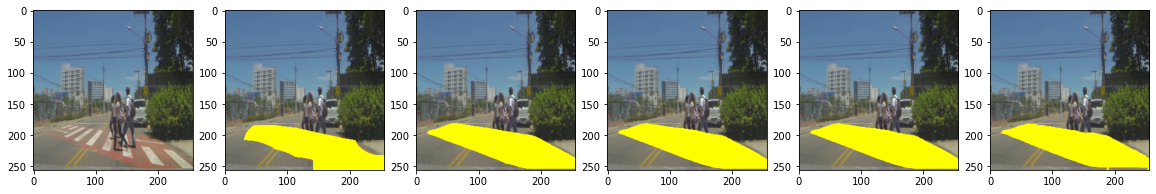

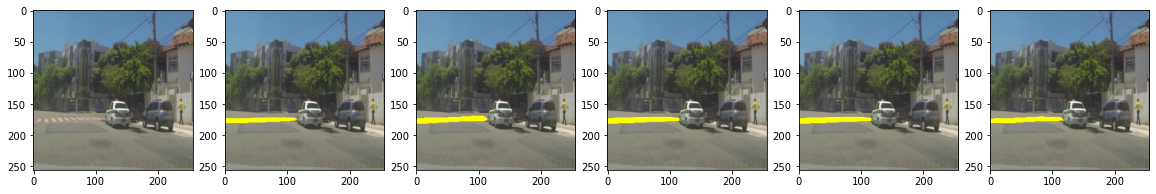

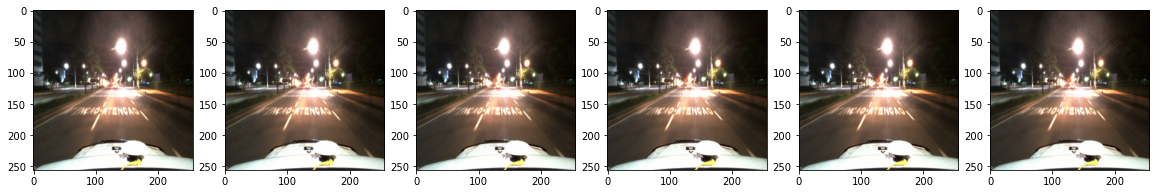

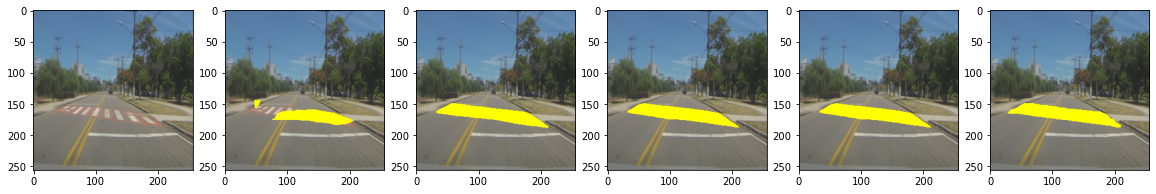

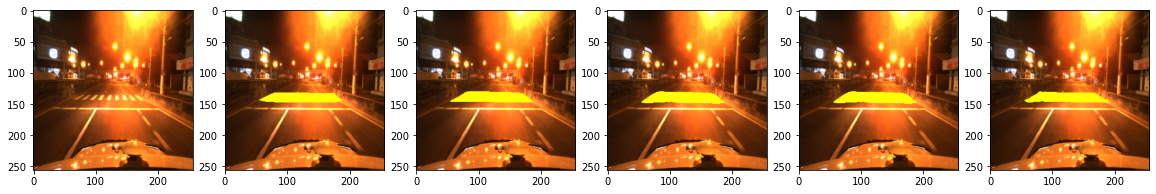

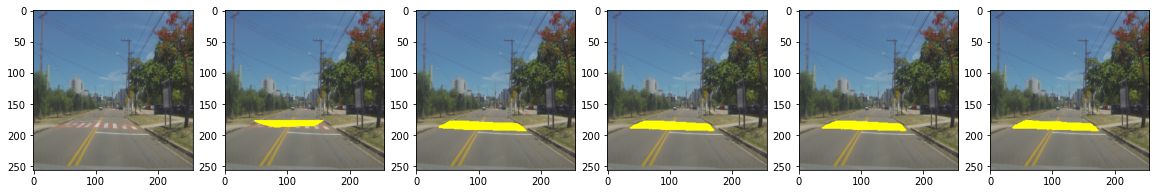

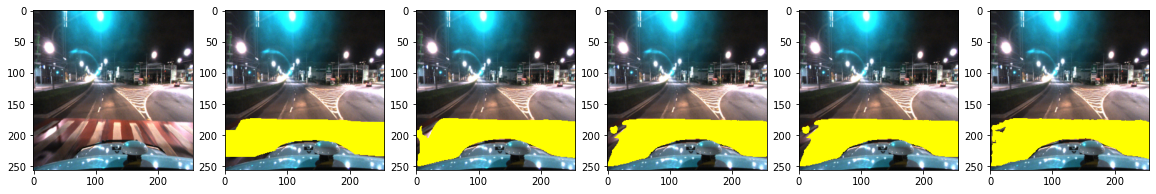

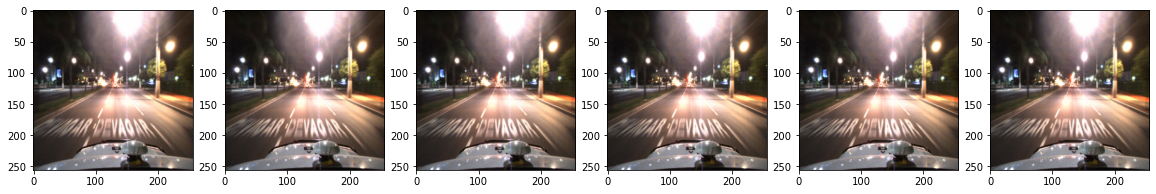

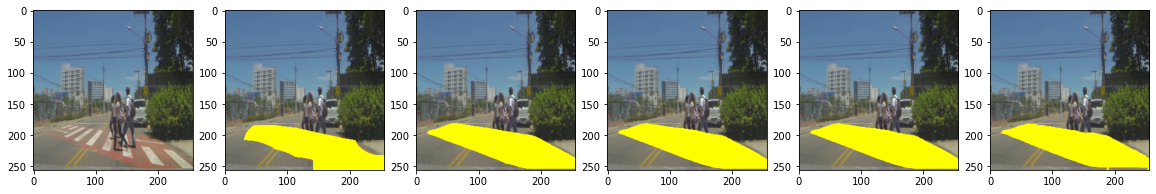

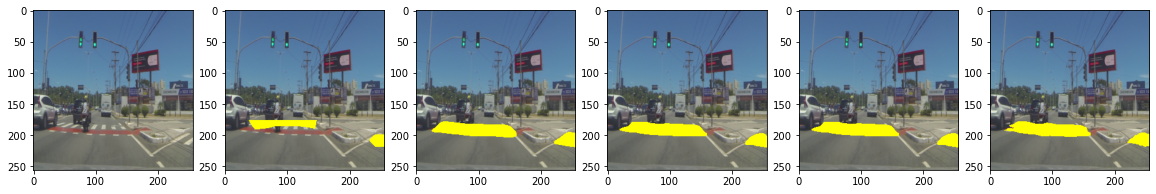

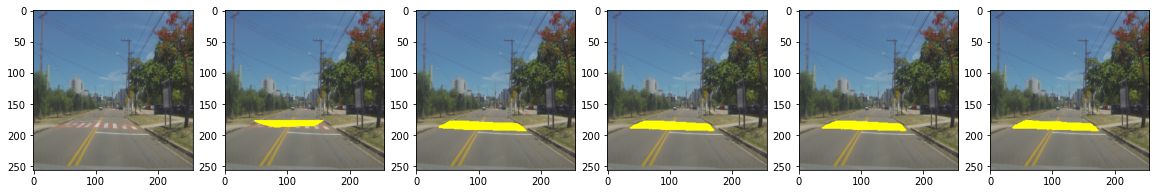

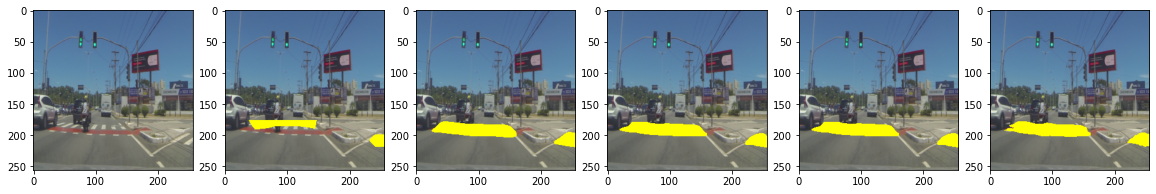

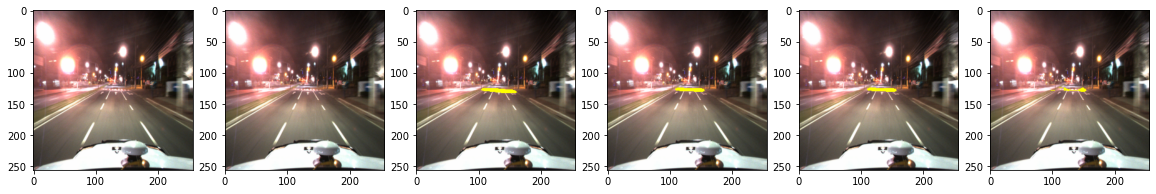

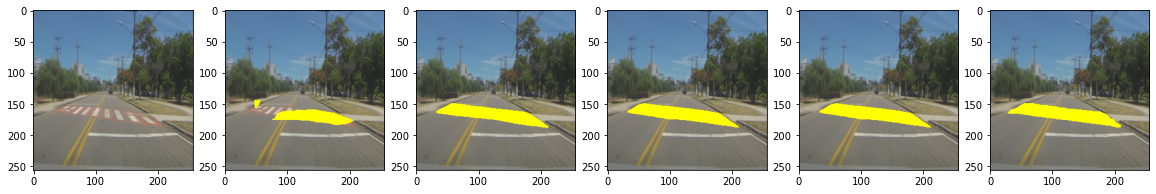

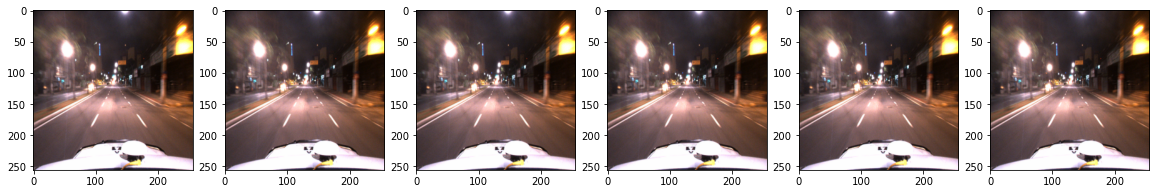

In [19]:
import matplotlib
import matplotlib.pyplot as plt

def draw_mask(image, mask):
    result = np.zeros((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            result[i][j] = [255, 255, 0] if mask[i][j] > 0.5 else image[i][j]
    return result

fcn_model.load_weights('models/fcn_crosswalks.h5')
segnet_model.load_weights('models/segnet_crosswalks.h5')
unet_model.load_weights('models/unet_crosswalks.h5')
unet_x_model.load_weights('models/unet_x_crosswalks.h5')
deepLab_model.load_weights('models/deeplab_crosswalks.h5')

num_of_test_images = 20
_, x_valid, _, _ = train_test_split(X_train, Y_train, test_size=0.3, random_state=2533)
x_valid = x_valid[:num_of_test_images]
fcn_pred = fcn_model.predict(x_valid)
segnet_pred = segnet_model.predict(x_valid)
unet_pred = unet_model.predict(x_valid)
unet_x_pred = unet_model.predict(x_valid)
deepLab_pred = deepLab_model.predict(x_valid)

random.seed = 13214

for image_index in range(len(x_valid)):
    image_index = int(random.random() * len(x_valid))
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 30))
    axes[0].imshow(x_valid[image_index])
    axes[1].imshow(draw_mask(x_valid[image_index], fcn_pred[image_index]))
    axes[2].imshow(draw_mask(x_valid[image_index], segnet_pred[image_index]))
    axes[3].imshow(draw_mask(x_valid[image_index], unet_pred[image_index]))
    axes[4].imshow(draw_mask(x_valid[image_index], unet_x_pred[image_index]))
    axes[5].imshow(draw_mask(x_valid[image_index], deepLab_pred[image_index]))
  